In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.integrate import quad, newton_cotes

from integral_functions.weight_functions import get_weights

First, I just want to write everything down so I have it front of me, and so I can define all the relevant notation. We want to find the vector $\theta$ that minimizes the general negative log-likelihood:
$\begin{align}
    -l(\theta ;, y) \approx -y\log (\sigma (q_\theta)) - (1-y)\log (1 - \sigma (q_\theta))
\end{align}$
where $\sigma$ is the link function, and
$\begin{align}
    q_\theta = \sum_{i=1}^{n_b - 1}P_i h_\theta (m_i) + P_L h_\theta (m_1) + P_R h_\theta (m_{n_b}).
\end{align}$
Here, $P_i = (x_{i+1} - x_i)p_i$, where $x_{i+1} - x_i$ is the population in a bin $i$, and $p_i$ is the population density within each bin. We make the modelling choice that each bin has a piecewise constant density. On the boundaries, we have $P_L = (x_2 - L)p_1$ and $P_R = (U - x_{n_b})p_{n_b}$. Here $y$ is prevalence, or something along those lines.

Importantly, we have information that we know and we have information we don't know. Essentially, we know the approximate values of the integrals of the form
$\begin{align}
    \int_{a}^b f_k(x)p_i(x) \mathrm{d}x
\end{align}$
for a generic function $f$; we approximate this integral in the sums above with the $P_i`s$. Obviously, we also know the $p_i`s$, since we need this to compute the integrals. We also know the values of $y$, which are data that may be of the form of counts or the like. For now, I will generate all of this data, and assume that $y\sim\mathcal{N}(\mu,\sigma^2 I)$. However, we don't know the overall function $f$, which we can write as
$$
f(x) = \sum_{i=1}^{n_b} \theta_k f_k(x).
$$
Thus, we seek the vector $\theta$ to fit this function $f$, given the values we do know of $f_k$.

Now we are going to write some code to see if some of our ideas our working. First, we'll be looking at the integral discretization for some function whose expectation we should know. We are going to assume that $\sigma$ is the identity function so as to not think about it in this moment. In our example, we are going to assume that the $x$ values are ages.

In [22]:
L = 20
U = 40
discretizations = [20, 25, 30, 35, 40]
midpoints = [
    (discretizations[i] + (discretizations[i - 1])) / 2
    for i in range(1, len(discretizations))
]

# Actual age bins
age_bins = [(20, 24), (25, 29), (30, 34), (35, 39)]

random_data = []
for start, end in age_bins:
    num_data_points = np.random.randint(5, 20)
    ages = np.random.randint(start, end + 1, num_data_points)
    random_data.append(ages)

In [23]:
# Get population for each bin
populations = np.array([arr.shape[0] for arr in random_data])
total_population = np.sum(populations)

# Here we assume constant density in each bin
population_densities = populations / total_population

In [24]:
# Define the function we're integrating over
def f(x):
    return x**2


def int_f(x):
    return x**3 / 3

We now have the necessary information to approximate the integrals

In [25]:
inner_integral_values = [
    f(midpoints[x])
    * population_densities[x]
    * (discretizations[x + 1] - discretizations[x])
    for x in range(len(midpoints))
]

weights = [
    population_densities[x] * (discretizations[x + 1] - discretizations[x])
    for x in range(len(midpoints))
]

function_evaluations = [f(midpoint) for midpoint in midpoints]

np.dot(np.array(weights), np.array(function_evaluations))

# total_integral = np.sum(inner_integral_values)
# total_integral

4507.440476190476

In [39]:
newton_weights = newton_cotes(3)[0]
newton_weights *= np.diff(discretizations)
newton_weights *= population_densities
np.dot(np.array(newton_weights), np.array(function_evaluations))

3614.3973214285716

In [36]:
newton_weights

array([0.44642857, 1.69642857, 1.51785714, 0.35714286])

In [37]:
weights

[1.1904761904761905, 1.507936507936508, 1.349206349206349, 0.9523809523809523]

In [38]:
check_integral_values = [
    population_densities[x]
    * (int_f(discretizations[x + 1]) - int_f(discretizations[x]))
    for x in range(len(population_densities))
]
np.sum(check_integral_values)

4517.857142857142

Having done a very toy example, we are now going to define functions that will do a lot of this generally so we can do this for multiple $k$. Note that we are running this on bins that are decided *randomly*. This is an intentional decision since it is easier to run the code and to not have to generate everything by hand for every run through of the function. However, we are still deterministically calculating the discretization points that induce the age bins. As a consequence, we are also deterministically generating the grid points (the midpoints). This is ok because we just need to be able to calculate the weights. Also, we can check that this makes sense because we explicitly define our functions and their integrals so as to calculate the exact integrals later on.

In [186]:
def get_discretizations(L, U, grid_points):
    grid_points = np.asarray(grid_points)
    grid_len = grid_points.shape[0]

    def grid_to_disc(discpoint, gridpoint):
        assert gridpoint > discpoint
        return 2 * gridpoint - discpoint

    disc_list = [grid_to_disc(L, grid_points[0])]
    for i in range(1, grid_len):
        discpoint = disc_list[i - 1]
        gridpoint = grid_points[i]
        disc_list.append(grid_to_disc(discpoint, gridpoint))
    disc_list.insert(0, L)
    assert disc_list[-1] == U

    return np.array(disc_list)


def age_bin_gen(discretizations):
    age_bins = []
    for i in range(1, len(discretizations)):
        first_age = discretizations[i - 1]
        second_age = discretizations[i] - 1
        age_bins.append((first_age, second_age))
    return age_bins


def assign_age_bins(age_bins):
    random_data = []
    for start, end in age_bins:
        num_data_points = np.random.randint(5, 20)
        ages = np.random.randint(start, end + 1, num_data_points)
        random_data.append(ages)
    return random_data


def pop_density_gen(random_data):
    # Get population for each bin
    populations = np.array([arr.shape[0] for arr in random_data])
    total_population = np.sum(populations)

    # Here we assume constant density in each bin
    return populations / total_population


def get_function_evaluations(midpoints, f):
    function_evaluations = [f(midpoint) for midpoint in midpoints]
    return np.array(function_evaluations)


def get_weights(L, U, population_density, grid_points):
    discretizations = get_discretizations(L, U, grid_points)
    # weights = []
    # for i in range(len(population_density)):
    #     pop = population_density[i]
    #     # Here, you could just do np.diff() and it will acheive the same purpose.
    #     diff = discretizations[i + 1] - discretizations[i]
    # # After np.diff(), you could simply use * operation
    #     weights.append(pop * diff)
    discretizations_diff = np.diff(discretizations)
    weights = population_density * discretizations_diff

    return weights


def check_integrals(L, U, population_density, grid_points, int_f):
    discretizations = get_discretizations(L, U, grid_points)
    integrals = []
    for x in range(len(population_density)):
        pop = population_density[x]
        diff = int_f(discretizations[x + 1]) - int_f(discretizations[x])
        integrals.append(pop * diff)
    return np.array(integrals)

Now I am going to define a series of polynomial functions that will serve as our $f_k$ functions. It won't really matter which one is which. I am going to assume that $k=4$.

In [187]:
k = 4


def f_1(x):
    return 3 * x**2 + 0.5 * x + 3


def int_f_1(x):
    return x**3 + 0.25 * x**2 + 3 * x


def f_2(x):
    return x**3 + 27


def int_f_2(x):
    return 0.25 * x**4 + 27 * x


def f_3(x):
    return 1 / 5 * x**4 + 30 * x


def int_f_3(x):
    return 1 / 25 * x**5 + 15 * x**2


def f_4(x):
    return 42 * x + 3


def int_f_4(x):
    return 21 * x**2 + 3 * x


f_list = [f_1, f_2, f_3, f_4]
int_f_list = [int_f_1, int_f_2, int_f_3, int_f_4]
L_list = [25, 30, 27, 19]
U_list = [45, 47, 43, 31]
grid_list = [
    [27.5, 32.5, 37.5, 42.5],
    [(30 + 34) / 2, (34 + 38) / 2, (38 + 42) / 2, (42 + 47) / 2],
    [(27 + 32) / 2, (32 + 37) / 2, (37 + 42) / 2, (42 + 43) / 2],
    [(19 + 22) / 2, (22 + 25) / 2, (25 + 28) / 2, (28 + 31) / 2],
]
discretizations = [
    get_discretizations(L_list[i], U_list[i], grid_list[i]) for i in range(k)
]
population_densities = [
    pop_density_gen(assign_age_bins(age_bin_gen(discretization)))
    for discretization in discretizations
]
weights = [
    get_weights(L_list[i], U_list[i], population_densities[i], grid_list[i])
    for i in range(k)
]
function_evaluations = [
    get_function_evaluations(grid_list[i], f_list[i]) for i in range(k)
]
integral_approx = [np.dot(weights[i], function_evaluations[i]) for i in range(k)]
integrals = [
    np.sum(
        check_integrals(
            L_list[i], U_list[i], population_densities[i], grid_list[i], int_f_list[i]
        )
    )
    for i in range(k)
]

In [188]:
integral_approx

[19899.598214285714, 271728.52702702704, 1229513.4405487806, 3186.0]

In [189]:
integrals

[19930.848214285714, 272568.72972972976, 1239500.003902439, 3186.0]

In [190]:
weights

[array([0.625     , 1.60714286, 1.42857143, 1.33928571]),
 array([0.75675676, 1.18918919, 0.75675676, 1.62162162]),
 array([0.97560976, 1.34146341, 0.97560976, 0.34146341]),
 array([0.58928571, 0.80357143, 0.91071429, 0.69642857])]

From the above, we can tell that everything is reasonably accurate. Now, we are going to collect our data in a more organized fashion, collecting all the weights into a matrix.

In [171]:
W = np.vstack(weights)

In [172]:
W

array([[0.9375    , 0.9375    , 1.875     , 1.25      ],
       [1.2244898 , 1.14285714, 1.14285714, 0.6122449 ],
       [1.66666667, 1.77083333, 0.9375    , 0.125     ],
       [0.86538462, 1.03846154, 0.80769231, 0.28846154]])

First, we are going to assign a matrix $X$ that will serve as the design matrix. We are also going to generate a $y$ vector so we can do inference on $\theta$ according to the following functional form:
$$ y = X\theta .
$$

In [173]:
X = np.array(
    [
        [-27.3, 54.8, 89.7, 91.2],
        [12.5, 90.6, -11.03, 42.4],
        [67.5, -59.23, 74.32, 77.7],
        [56.421, 24.39, 34, -81.215],
    ]
)

y = np.random.randint(10, size=k)

# theta_true = np.linalg.inv(X.T @ X) @ X.T @ y
theta_true = np.linalg.inv(X.T) @ y

In [174]:
theta_true

array([0.02331059, 0.08822944, 0.03990121, 0.08578684])

Now we want to run a regression on our problem. To do this, we assign a $z$ vector of dimension $4\times 1$ of known outcomes where we assume $z = Wy + \epsilon$, where $\epsilon \sim \mathcal{N}(0,I)$. We also assume an $X$ matrix of known covariates of size $4\times 4$ (which is the same as in the example immemdiately preceding). We can then do do inference on our unknown parameter $\theta$ by
$$
    \hat\theta = ((WX)^\top (WX))^{-1} (WX)z.
$$

In [175]:
z = W @ y + np.random.randn(k)

WX = W @ X
varWX = np.linalg.inv(WX.T @ WX)
theta = varWX @ WX.T @ z

In [176]:
theta

array([ 0.13187651,  0.12378492, -0.0073583 ,  0.02024947])

Text(0, 0.5, '$\\theta_i$ value')

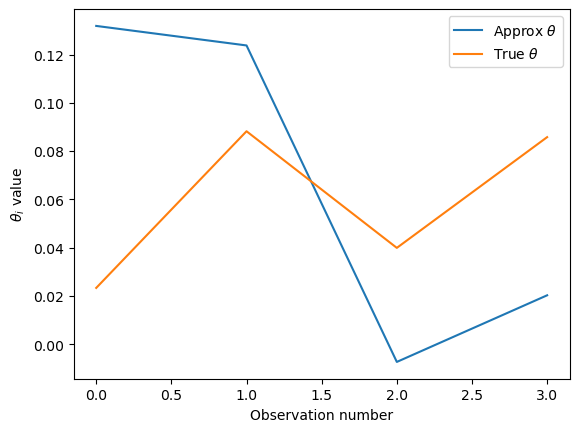

In [177]:
k_array = np.arange(0, k)
plt.plot(k_array, theta, label=r"Approx $\theta$")
plt.plot(k_array, theta_true, label=r"True $\theta$")
plt.legend()
plt.xlabel("Observation number")
plt.ylabel(r"$\theta_i$ value")

In [184]:
num_trials = 1000
# theta_true_list = []
theta_approx_list = []
y = np.random.randint(10, size=k)
X = np.array(
    [
        [-27.3, 54.8, 89.7, 91.2],
        [12.5, 90.6, -11.03, 42.4],
        [67.5, -59.23, 74.32, 77.7],
        [56.421, 24.39, 34, -81.215],
    ]
)
theta_true = np.linalg.inv(X.T) @ y
for _ in range(num_trials):
    # X = np.random.normal(6., 5., size=(k,k))
    # y = np.random.randint(10, size=k)
    # theta_true = np.linalg.inv(X.T) @ y
    # theta_true_list.append(theta_true)

    z = W @ y + np.random.randn(k)
    WX = W @ X
    varWX = np.linalg.inv(WX.T @ WX)
    theta = varWX @ WX.T @ z
    theta_approx_list.append(theta)

theta_approx_array = np.vstack(theta_approx_list)
theta_approx_avg = np.mean(theta_approx_array, axis=0)
theta_approx_std = np.std(theta_approx_array, axis=0)

Text(0, 0.5, '$\\theta_i$ value')

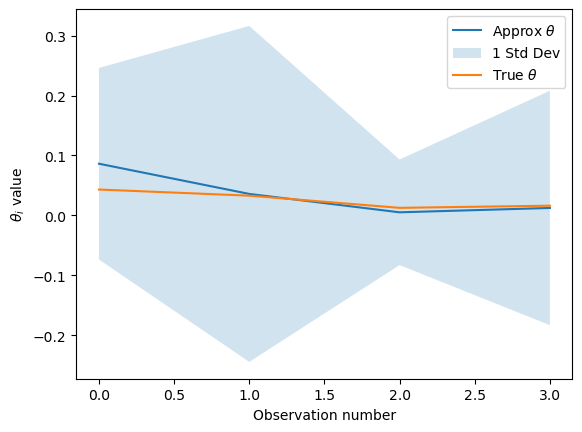

In [185]:
plt.plot(k_array, theta_approx_avg, label=r"Approx $\theta$")
plt.fill_between(k_array, theta_approx_avg - theta_approx_std, theta_approx_avg + theta_approx_std, alpha=0.2, label="1 Std Dev")
plt.plot(k_array, theta_true, label=r"True $\theta$")
plt.legend()
plt.xlabel("Observation number")
plt.ylabel(r"$\theta_i$ value")

Next, want to test how this performs with different likelihoods, like, for instance, with binomial likelihood.